<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/12_spectral_analysis_continued/12_workalong_01_filter.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Simple filtering

This notebook demonstrates using the FFT to filter timeseries data.  It also demonstrates a higher-quality approach using a [Butterworth fitler](https://en.wikipedia.org/wiki/Butterworth_filter).

In [2]:
""" Import libraries. """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

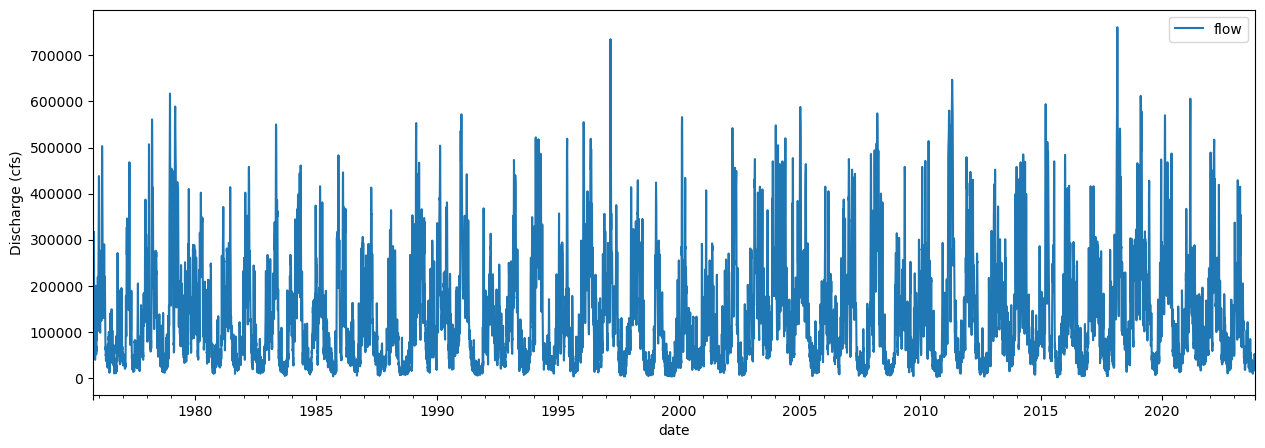

In [3]:
""" Load the data file. """

streamflow_url = "https://raw.githubusercontent.com/taobrienlbl/advanced_earth_science_data_analysis/spring_2023_iub/lessons/11_spectral_analysis_intro/cannelton_flow.dat"
skiprows = 30

# load the data
data = pd.read_csv(
    streamflow_url,
    skiprows = skiprows,
    delim_whitespace = True,
    names = ['org', 'id', 'date', 'flow', 'flag'],
    parse_dates=['date'],
    )

fig, ax = plt.subplots()
data.plot(ax = ax, x='date', y='flow', figsize=(15,5))
ax.set_ylabel('Discharge (cfs)')
plt.show()

/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_14431/1797071885.py:12: RuntimeWarning: divide by zero encountered in divide
  period = 1/freqs # seconds


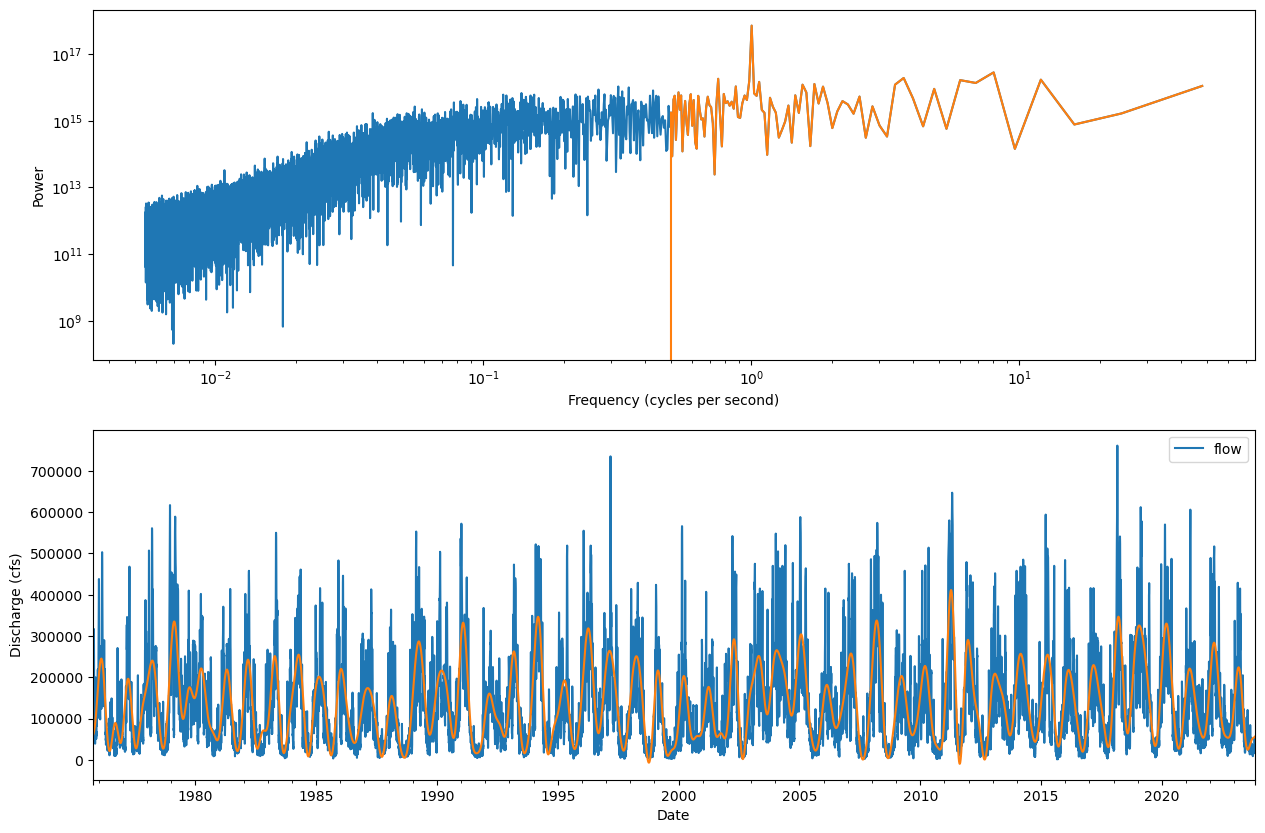

this many seconds: 0.4549849033355713


In [27]:
import time
start = time.time()
""" Filter the data using a naive cutoff filter. """
# get the fourier transform of the data
dischar_fft = np.fft.rfft(data['flow'])

# get the frequencies associated with the fourier transform
dt = 1 # days
dt = dt*24*60*60 # seconds
freqs = np.fft.rfftfreq(len(data['flow']), dt) # cycles per second
# convert to cycles per year
period = 1/freqs # seconds
period = period/(365.25*24*60*60) # years

# define the cutoff frequency = 0.5 years
cutoff_period = 0.5 # years
cutoff_period = cutoff_period*365.25*24*60*60 # seconds
cutoff_freq = 1/cutoff_period # cycles per second

# find the frequencies above the cutoff frequency
i_high_freqs = freqs > cutoff_freq

# set the high frequencies to zero
discharge_fft_filtered = dischar_fft.copy()
discharge_fft_filtered[i_high_freqs] = 0 

# invert the fourier transform to get the filtered data
discharge_filtered = np.fft.irfft(discharge_fft_filtered)

# plot the power spectrum
# make the power spectrum first
freq_power = np.abs(dischar_fft)**2

fig, axs = plt.subplots(2,1, figsize=(15,10))

# plot the power spectrum whole
ax = axs[0]
ax.plot(period, freq_power)
# plot the filtered power spectrum
ax.plot(period, np.abs(discharge_fft_filtered)**2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (cycles per second)')
ax.set_ylabel('Power')


# the time series
ax = axs[1]
data.plot(ax=ax, x='date', y='flow', figsize=(15,10))
ax.plot(data['date'], discharge_filtered)
ax.set_ylabel('Discharge (cfs)')
ax.set_xlabel('Date')

plt.show()

print(f"this many seconds: {time.time() - start}")

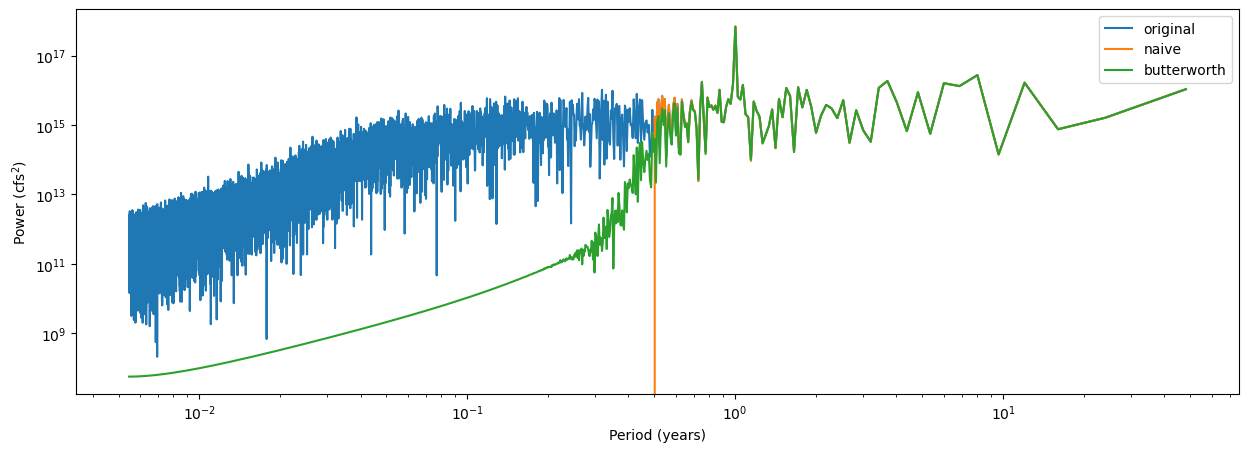

8787 8787


In [36]:
""" Filter the data using a Butterworth filter. """

from scipy.signal import butter, filtfilt

# define the butterworth filter
order = 5

# define the cutoff frequency = 0.5 years
cutoff_period = 0.5 # years
cutoff_period = cutoff_period*365.25*24*60*60 # seconds
cutoff_freq = 1/cutoff_period # cycles per second

# get the Nyquist frequency
dt = 1 # days
dt = dt*24*60*60 # seconds
nyquist_freq = 1/(2*dt) # cycles per second

# normalize the cutoff frequency
cutoff_freq_norm = cutoff_freq/nyquist_freq

# get the butterworth filter coefficients
b, a = butter(order, cutoff_freq_norm, btype='lowpass')

# filter the data
discharge_filt_butter = filtfilt(b, a, data['flow'])

# fft of the filtered data
discharge_fft_butter = np.fft.rfft(discharge_filt_butter)

# plot the three power spectra
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(period, np.abs(dischar_fft)**2, label='original')
ax.plot(period, np.abs(discharge_fft_filtered)**2, label='naive')
ax.plot(period, np.abs(discharge_fft_butter)**2, label='butterworth')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Period (years)')
ax.set_ylabel('Power (cfs$^2$)')
ax.legend()

# ax.axvline(np.max(np.abs(discharge_fft_butter)**2), color='k', linestyle='--')

plt.show()

# find the frequency with the maximum power
print(len(period), len(np.abs(discharge_fft_butter)**2))


In [41]:
power = np.abs(discharge_fft_butter)**2
i_max_power = np.argmax(power)
print(i_max_power, np.max(power))
print(power[i_max_power])
power

0 5.746047059647316e+18
5.746047059647316e+18


array([5.74604706e+18, 1.08507665e+16, 1.63010925e+15, ...,
       5.61729887e+07, 5.61729833e+07, 5.61729815e+07])

In [ ]:
""" Calculate and plot the high-pass data """


